# Supervised learning for time series <a class="tocSkip">

[Tomas Beuzen](https://tomasbeuzen.github.io/), April 2020

---

# Introduction

## Objectives

- Learn how to wrangle time series for supervised learning
- Use classic supervised learning for modelling time series data
- Use deep learning for modelling time series data

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_validate
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 16,
                     'axes.labelweight': 'bold',
                     'figure.figsize': (8,6)})

## Custom functions

In [2]:
# Custom functions
def lag_df(df, lag, cols):
    return df.assign(**{f"{col}-{n}": df[col].shift(n) for n in range(1, lag + 1) for col in cols})


def ts_predict(input_data, model, n=20, responses=1):
    predictions = []
    n_features = input_data.size
    for _ in range(n):

        predictions = np.append(predictions,
                                model.predict(input_data.reshape(1, -1)))  # make prediction
        input_data = np.append(predictions[-responses:],
                               input_data[:n_features-responses])  # new input data
    return predictions.reshape((-1, responses))


def plot_ts(ax, df_train, df_test, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(df_test[col], '--', c=col_cycle[i], label = f'Test {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+1)
    ax.set_title(f"Train Shape = {len(df_train)}, Test Shape = {len(df_test)}",
                fontsize=14)
    ax.set_ylabel(df_train.columns[0])

        
def plot_forecast(ax, df_train, predictions, xlim, response_cols):
    col_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, col in enumerate(response_cols):
        ax.plot(df_train[col], '-', c=col_cycle[i], label = f'Train {col}')
        ax.plot(np.arange(df_train.index[-1] + 1,
                          df_train.index[-1] + 1 + len(predictions)),
                predictions[:,i], '-', c=col_cycle[-i-2], label = f'Prediction {col}')
    ax.set_xlim(0, xlim+len(predictions))
    ax.set_title(f"{len(predictions)}-step forecast",
                    fontsize=14)
    ax.set_ylabel(response_cols)
    
def create_rolling_features(df, columns, windows=[6, 12]):
    for window in windows:
        df["rolling_mean_" + str(window)] = df[columns].rolling(window=window).mean()
        df["rolling_std_" + str(window)] = df[columns].rolling(window=window).std()
        df["rolling_var_" + str(window)] = df[columns].rolling(window=window).var()
        df["rolling_min_" + str(window)] = df[columns].rolling(window=window).min()
        df["rolling_max_" + str(window)] = df[columns].rolling(window=window).max()
        df["rolling_min_max_ratio_" + str(window)] = df["rolling_min_" + str(window)] / df["rolling_max_" + str(window)]
        df["rolling_min_max_diff_" + str(window)] = df["rolling_max_" + str(window)] - df["rolling_min_" + str(window)]

    df = df.replace([np.inf, -np.inf], np.nan)    
    df.fillna(0, inplace=True)
    return df

# Univariate time series

- We'll first explore univariate time series before generalising to the multivariate case
- Recall that a univariate time series is composed of observations of some quantity measured at consecutive intervals in time
- We will be assuming these "intervals" are regular (for irregular intervals, I recommend aggregating to a regular grid, like we did in DSCI 574)
- Our aim is to wrangle this data to make it suitable for supervised learning
- Recall that supervised learning is about learning a function that relates a features matrix, *X*, to the response, *y*
- Let's jump straight into an example

## Create some synthetic data

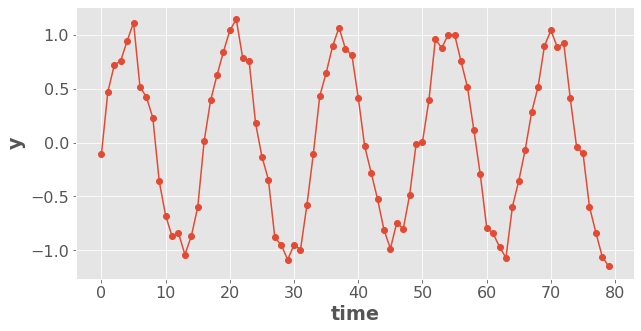

In [3]:
N = 80  # control the resolution of the sine wave
np.random.seed(123)
x = np.linspace(0, 30, N)
y = np.sin(x) + np.random.normal(0, 0.1, N) # sine wave with some added noise
plt.subplots(1, 1, figsize=(10, 5))
plt.plot(y, marker='o')
plt.xlabel('time')
plt.ylabel('y')
df = pd.DataFrame(y, columns=['y'])

In [4]:
df

,y
0,-0.108563
1,0.470420
2,0.716852
3,0.757687
4,0.940798
...,...
75,-0.101238
76,-0.593724
77,-0.835319
78,-1.058573


## Wrangling the data

- When working with time series **we wish to use information from past values to help make predictions about future values**
- We often use the term "autocorrelation" in this context, i.e., the correlation of a variable with lagged versions of itself
- For supervised machine learning, we need an input feature matrix, *X*, and a response vector, *y*. 
- We can create an *X* by adding columns to our dataframe that are lagged versions of the response
- The pandas function `df.shift()` can help us here

In [5]:
df_lag = df
df_lag['y-1'] = df_lag['y'].shift(periods=1)  # shift back one time period
df_lag['y+1'] = df_lag['y'].shift(periods=-1)  # shift forward one time period
df_lag

,y,y-1,y+1
0,-0.108563,NaN,0.470420
1,0.470420,-0.108563,0.716852
2,0.716852,0.470420,0.757687
3,0.757687,0.716852,0.940798
4,0.940798,0.757687,1.111852
...,...,...,...
75,-0.101238,-0.040105,-0.593724
76,-0.593724,-0.101238,-0.835319
77,-0.835319,-0.593724,-1.058573
78,-1.058573,-0.835319,-1.148628


- Of course, we only want our model to be able to "see" the past, so we'll always be "shifting back"
- I've created a simple function (which we defined at the begining of the notebook) which will add an arbitrary number of columns to our dataframe

In [6]:
lag = 1
df_lag = lag_df(df, cols=['y'], lag=lag)
df_lag

,y,y-1,y+1
0,-0.108563,NaN,0.470420
1,0.470420,-0.108563,0.716852
2,0.716852,0.470420,0.757687
3,0.757687,0.716852,0.940798
4,0.940798,0.757687,1.111852
...,...,...,...
75,-0.101238,-0.040105,-0.593724
76,-0.593724,-0.101238,-0.835319
77,-0.835319,-0.593724,-1.058573
78,-1.058573,-0.835319,-1.148628


**A NOTE ON THE IID ASSUMPTION**
> In the example above, our *y* (the response) is the column "y" and our *X* is the column "y-1"
>
> Recall that supervised ML typically relies on the IID assumption - that each observation (row) of the dataset is independent and identically distributed
>
> Of course with a time series, rows are not independent (in fact, we wish to use the dependence to help with our modelling!)
> 
> However, you can think about what we are doing as encoding conditional independence - we are assuming that each row is independent of every other given the lagged features. In the end, the IID assumption is almost always violated to some degree - but I'm not all that concerned. The aim here is to create a predictive model and we can do this with the help of proper and systematic ML development e.g., by using separate training/validation/testing sets.

## Splitting the data into train/validation sets

- We now have an *X* and *y* to build our supervised learning model
- The next step is to split the data
- When working with time series we can't randomly split the data as we may be used to doing with supervised learning
- Why? Because we would disrupt the temporal order of the data and potentially leak information from the test/validation set into the training set
- For example, see the figure below. After randomly splitting our data, we get the same elements appearing in the train and test sets (i.e., we're training our model on something we later want to test it on!)

<img src="../docs/img/ts_1.png" alt="Drawing" style="width: 600px;"/>

- Instead we need to split data in a way that **preserves the temporal order of the data**
- The simplest method is to just take off a chunk at the end of the time series like this:

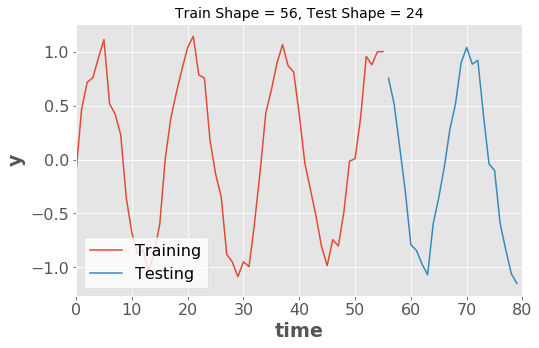

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(8,5))
split = int(0.7*len(df))
df_train = df_lag.iloc[:split]
df_test = df_lag.iloc[split:]
ax.plot(df_train['y'], label = 'Training')
ax.plot(df_test['y'], label = 'Testing')
ax.set_xlim(0, N)
ax.set_title(f"Train Shape = {len(df_train)}, Test Shape = {len(df_test)}",
                fontsize=14)
ax.set_ylabel('y')
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

- But we can do better than this!
- A more robust, cross-validation-like, approach, is to split the data multiple times incrementally and cumulatively
- We can do this with the help of the `sklearn.model_selection.TimeSeries()` function like this:

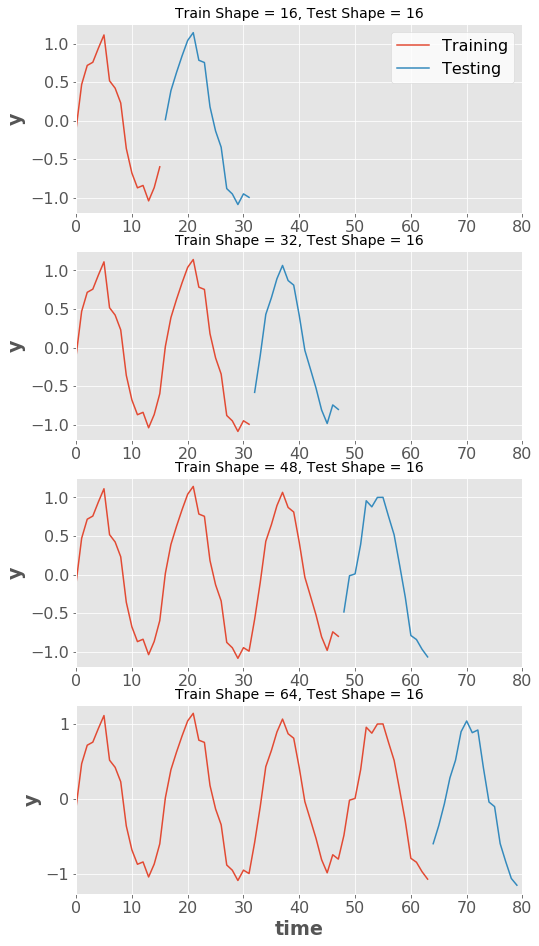

In [8]:
n_splits = 4
fig, ax = plt.subplots(n_splits, 1, figsize=(8,4*n_splits))
tscv = TimeSeriesSplit(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(tscv.split(df)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    ax[i].plot(df_train['y'], label = 'Training')
    ax[i].plot(df_test['y'], label = 'Testing')
    ax[i].set_xlim(0, N)
    ax[i].set_title(f"Train Shape = {len(train_index)}, Test Shape = {len(test_index)}",
                    fontsize=14)
    ax[i].set_ylabel('y')
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time');

## Building a model
- Okay, we have a suitable dataset and a way of splitting the data, now let's build a model
- We will try to model our synthetic dataset with a **random forest regression model**
- We'll explore two potential use cases:
    - Forecasting one time step ahead
    - Forecasting multiple time steps ahead

### Forecasting a single time step

- Our model is going to take in a lagged value(s) of the response and try to predict the value of the response at the current time
- We can test its performance by passing a `TimeSeriesSplit()` object into `cross_validate`

In [9]:
lag = 1  # vary the number of lagged features in the model
n_splits = 3  # vary the number of train/validation splits
response_col = ['y']
df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # definte the model
cv = cross_validate(model,
                    df_lag.drop(columns=response_col),
                    df_lag[response_col[0]],
                    cv=tscv,
                    return_train_score=True)
pd.DataFrame({'split': range(n_splits),
              'train_r2': cv['train_score'],
              'test_r2': cv['test_score']}).set_index('split')

,train_r2,test_r2
split,,
0,0.986365,0.959715
1,0.992220,0.932537
2,0.993002,0.966433


- We can also plot our results

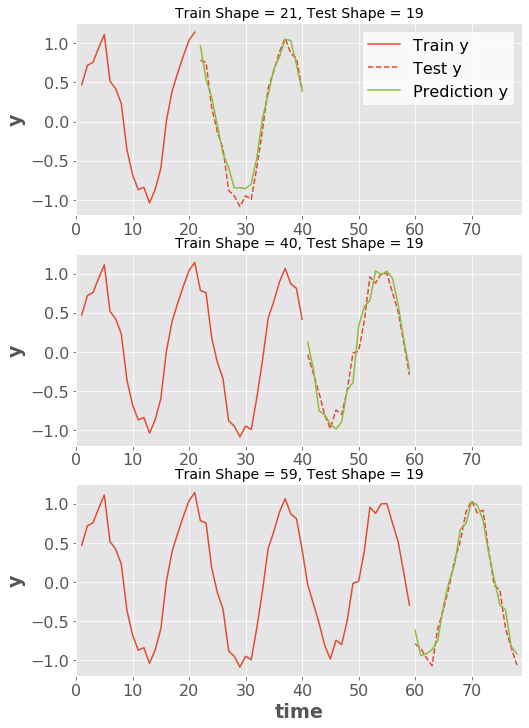

In [10]:
fig, ax = plt.subplots(n_splits, 1, figsize=(8,4*n_splits))
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    predictions = model.predict(df_test.drop(columns=response_col))[:,None]
    
    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time');

- Looks pretty good right?
- But this plot is a bit misleading...
- These are just the results of our model predicting one time step ahead, i.e., given inputs at time `t`, predict `t+1`
- If we want to see how well our model does at forecasting *multiple time steps* we'll need to do something different

### Forecasting multiple time steps

- When working with a model that predicts a response as a function of past values of that response, the only way we can forecast multiple steps ahead is with a **for loop**
- As we predict into the future (forecast), the prediction at time *t* will become an input to our model for predicting at time *t+1*
- Let's see how well our model does at predicting multiple steps in advance (where each prediction is fed back into the model to make the next prediction)

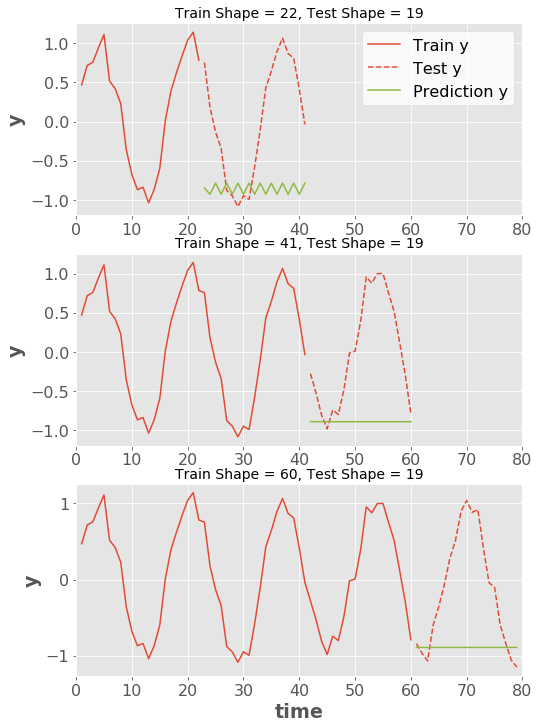

In [11]:
lag = 1  # vary the number of lagged features in the model
n_splits = 3  # vary the number of train/validation splits
response_col = ['y']
df = pd.DataFrame(y, columns=['y'])
fig, ax = plt.subplots(n_splits, 1, figsize=(8,4*n_splits))
df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=3)
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col[0]])  # train model
    # Prediction loop
    input_data = df_lag.iloc[-1, :lag*df.shape[1]].to_numpy()  # starting data for first prediction
    predictions = ts_predict(input_data, model, len(df_test))
    
    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time');

- Yikes! Our predictions are terrible!
- We probably need to increase the lag (i.e., add more features)...
- We have a pattern repeating itself every 15 values or so
- So let's try a lag of 15

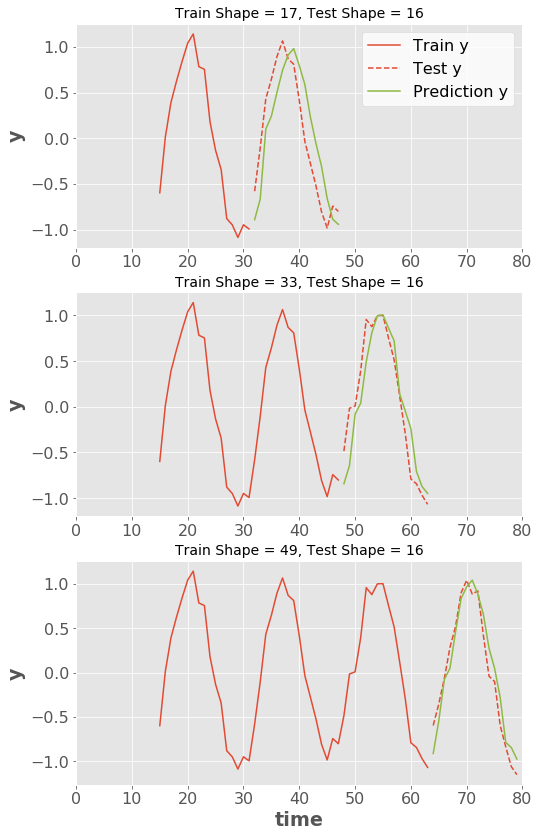

In [12]:
lag = 15
response_col = 'y'
fig, ax = plt.subplots(3, 1, figsize=(8,14))
df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=3)
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=response_col),
                                        df_train[response_col])  # train model
    # Prediction loop
    input_data = df_lag.iloc[-1, :lag*df.shape[1]].to_numpy()  # starting data for first prediction
    predictions = ts_predict(input_data, model, len(df_test))
    
    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time');

- Much better!
- But how do we choose the best lag?
- We can treat it as a hyperparameter and optimize it, e.g.:

In [13]:
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor()  # definte the model
# search loop
l = []
cv_mean = []
cv_std = []
response_col = 'y'
for lag in range(1, 21):
    df_lag = lag_df(df, lag, response_col).dropna()  # drop the na
    cv_score = cross_validate(model,
                              df_lag.drop(columns=response_col),
                              df_lag[response_col],
                              cv=tscv)
    l.append(lag)
    cv_mean.append(round(cv_score['test_score'].mean(),3))
    cv_std.append(round(cv_score['test_score'].std(),3))
(pd.DataFrame({'lag': l,
               'cv_mean': cv_mean,
               'cv_std': cv_std}).set_index('lag')
                                 .sort_values(by='cv_mean', ascending=False)
                                 .head(10)
)

,cv_mean,cv_std
lag,,
6,0.949,0.005
7,0.948,0.014
18,0.944,0.015
17,0.944,0.009
5,0.942,0.008
8,0.941,0.014
10,0.941,0.010
19,0.940,0.017
15,0.939,0.009


- There's not a huge difference in the performance of our model as the lag gets above 5
- Let's choose a lag of 7, re-train a model on the full dataset and use it to forecast an arbitrary number of points ahead

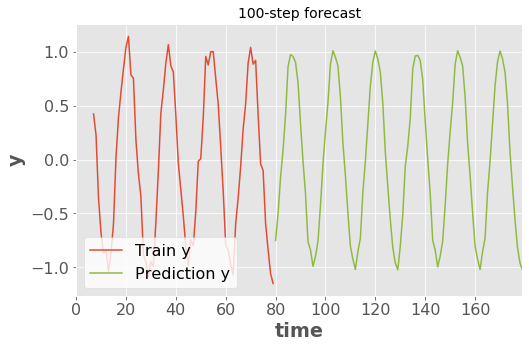

In [14]:
lag = 7
n = 100  # number of steps to forecast
response_col = 'y'
fig, ax = plt.subplots(1, 1, figsize=(8,5))
df_lag = lag_df(df, lag, response_col).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                    df_lag[response_col])  # train model
# Prediction loop
input_data = df_lag.iloc[-1, :lag*df.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n)

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=response_col)
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

- Not too bad at all, the forecast seems pretty reasonable!

## Working with a real time series

- Let's try out our ML workflow on a real time series
- The data we'll be using is of "Retail Sales of Clothing and Clothing Accessory Stores" made available by the Federal Reserve Bank of St Louis and can be accessed [here](https://fred.stlouisfed.org/series/MRTSSM448USN)

In [15]:
df = pd.read_csv('../data/sales_data.csv', index_col=0)
df

,sales
date,
1992-01-01,6938
1992-02-01,7524
1992-03-01,8475
1992-04-01,9401
1992-05-01,9558
...,...
2019-06-01,21123
2019-07-01,21714
2019-08-01,23791


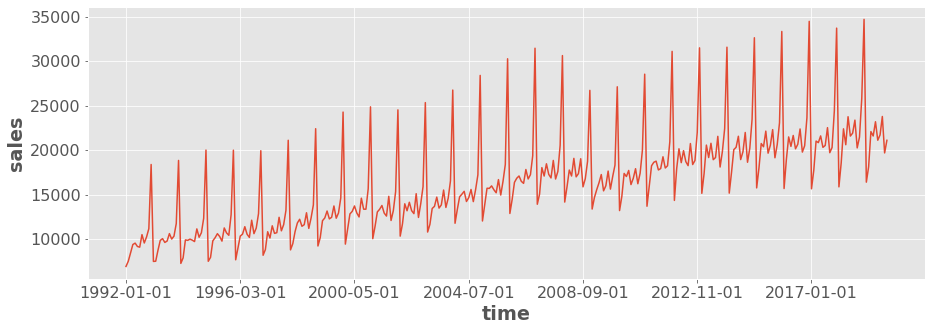

In [16]:
plt.subplots(1, 1, figsize=(15, 5))
df['sales'].plot()
plt.xlabel('time')
plt.ylabel('sales');

- Let's try forecasting this time series (using the exact same methods we used above) with different lags

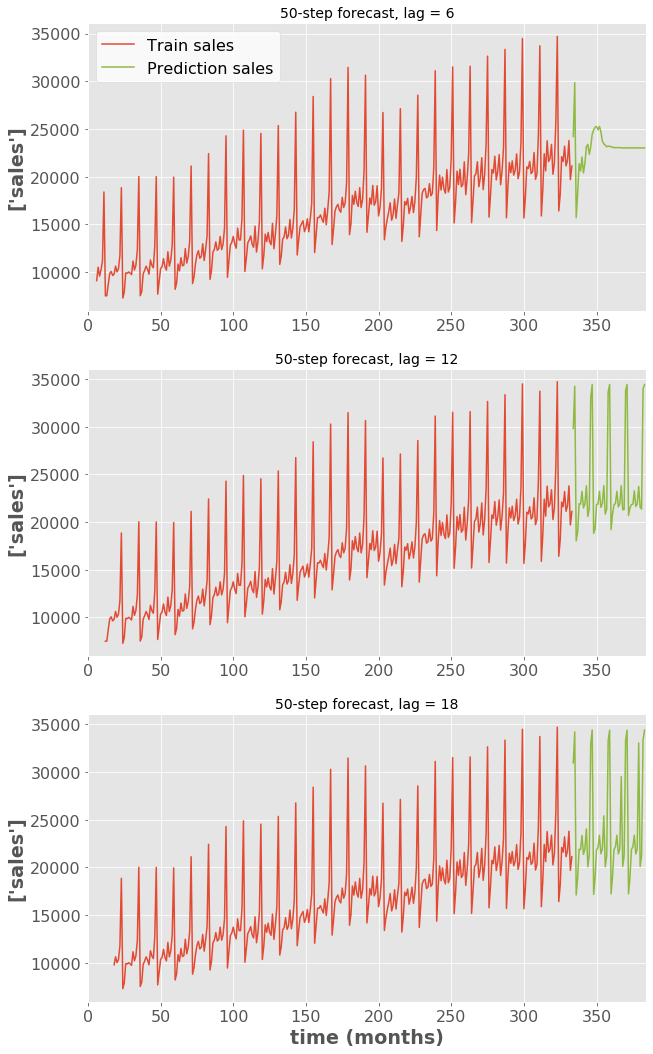

In [17]:
# Variable params
n = 50  # forecast length
lag = [6, 12, 18]  # lags to try
response_col = ['sales']
fig, ax = plt.subplots(len(lag), 1, figsize=(10,18))

# Calc loop
for k, l in enumerate(lag):

    df_lag = lag_df(df.reset_index().drop(columns='date'), l, [response_col]).dropna()
    model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                        df_lag[response_col[0]])  # train model
    # Prediction loop
    input_data = df_lag.iloc[-1, :l*df.shape[1]].to_numpy()  # starting data for first prediction
    predictions = ts_predict(input_data, model, n)

    # Plot
    plot_forecast(ax[k], df_lag, predictions, xlim=len(df_lag)+l, response_cols=response_col)
    ax[k].set_title(ax[k].get_title() + f', lag = {l}', fontsize=14)
    
ax[0].legend(facecolor='w')    
ax[k].set_xlabel('time (months)');

- Our forecasts don't look too bad (for higher lags)
- However, there's a pretty clear trend in our model which our random forest will not be able to capture
- It's typically better to work with stationary data, so let's try differencing first to coerce our data to be stationary

In [18]:
# reload clean data
df = pd.read_csv('../data/sales_data.csv', index_col=0)

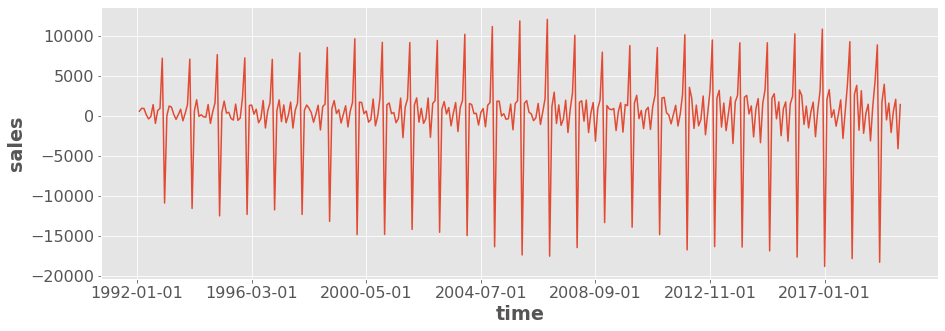

In [19]:
plt.subplots(1, 1, figsize=(15, 5))
df['sales'].diff().plot()
plt.xlabel('time')
plt.ylabel('sales');

- Let's try forecasting this time series (using the exact same methods we used above) with different lags

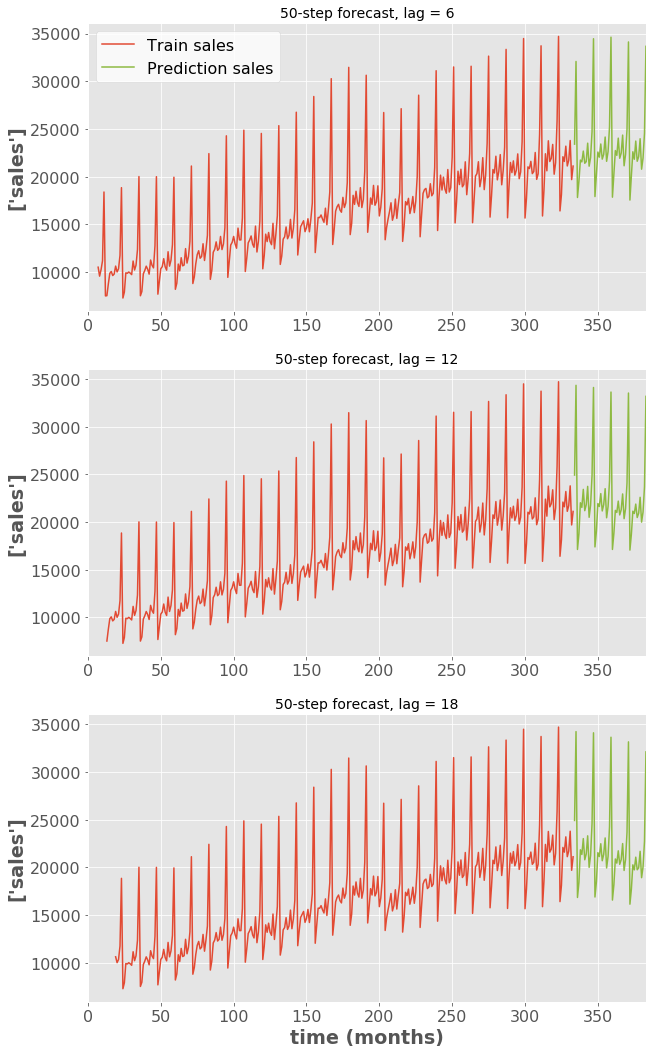

In [20]:
# Variable params
n = 50
lag = [6, 12, 18]
fig, ax = plt.subplots(len(lag), 1, figsize=(10,18))
response_col = ['sales']

# Calc loop
for k, l in enumerate(lag):

    df_lag = lag_df(df.reset_index().drop(columns='date'), l, response_col).dropna()
    df_start = df_lag.to_numpy()[0, 0]
    df_end = df_lag.to_numpy()[-1, 0]
    df_lag = df_lag.diff().dropna()
    model = RandomForestRegressor().fit(df_lag.drop(columns=response_col),
                                        df_lag[response_col[0]])  # train model
    # Prediction loop
    input_data = df_lag.iloc[-1, :l*df.shape[1]].to_numpy()  # starting data for first prediction
    predictions = ts_predict(input_data, model, n)

    # Plot
    plot_forecast(ax[k], df_lag[response_col].cumsum() + df_start,
                  np.atleast_2d(np.cumsum(predictions) + df_end).T,
                  xlim=len(df_lag)+l,
                  response_cols=response_col)
    ax[k].set_title(ax[k].get_title() + f', lag = {l}', fontsize=14)
    
ax[0].legend(facecolor='w')    
ax[k].set_xlabel('time (months)');

- Nice! Now it seems we can at least model a bit of a trend
- We could potentially improve our model by including seasonal differencing or doing some more feature engineering...

## More feature engineering

### Time stamps

- In the examples above we are only incorporating temporal dependence by lagging the response variable
- However, with time-stamped data we may also want to include additional information as features, for example, what month of the year data was recorded, what quarter, was it morning or evening, etc.
- It looks like there's definitely some seasonal pattern in the data above, with a cycle around 12 months
- We could explicitly add the name of the month that an observation was recorded in as a feature to our dataframe as follows

In [21]:
df = pd.read_csv('../data/sales_data.csv', index_col=0, parse_dates=True)
df_months = df.copy()
df_months['month'] = df.index.month_name()
df_months

,sales,month
date,,
1992-01-01,6938,January
1992-02-01,7524,February
1992-03-01,8475,March
1992-04-01,9401,April
1992-05-01,9558,May
...,...,...
2019-06-01,21123,June
2019-07-01,21714,July
2019-08-01,23791,August


### Rolling windows

- Another option is to look at rolling window stats
- For example, rather than looking at just the values of past values, look at the range of the previous *n* values, or the mean, or median, etc.

In [22]:
df_rolling = df.copy()
df_rolling = create_rolling_features(df_rolling, columns='sales')
df_rolling.sample(3)

,sales,rolling_mean_6,rolling_std_6,rolling_var_6,rolling_min_6,rolling_max_6,rolling_min_max_ratio_6,rolling_min_max_diff_6,rolling_mean_12,rolling_std_12,rolling_var_12,rolling_min_12,rolling_max_12,rolling_min_max_ratio_12,rolling_min_max_diff_12
date,,,,,,,,,,,,,,,
1993-06-01,9635,8892.833333,1157.005690,1.338662e+06,7502.0,10063.0,0.745503,2561.0,10198.500000,2808.671783,7.888637e+06,7502.0,18395.0,0.407828,10893.0
1994-07-01,9735,9554.833333,814.582204,6.635442e+05,7902.0,10009.0,0.789489,2107.0,10517.250000,2870.645481,8.240605e+06,7280.0,18851.0,0.386186,11571.0
1996-06-01,10554,9925.500000,1347.314180,1.815256e+06,7684.0,11405.0,0.673740,3721.0,11208.583333,3038.101574,9.230061e+06,7684.0,20002.0,0.384162,12318.0


### Let's score all the methods

In [23]:
# Just lag
lag = 12  # vary the number of lagged features in the model
n_splits = 5  # vary the number of train/validation splits
response_col = ['sales']
df_lag = lag_df(df, lag, response_col).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)  # define the splitter
model = RandomForestRegressor(random_state=123)  # definte the model
cv = cross_validate(model,
                    df_lag.drop(columns=response_col),
                    df_lag[response_col[0]],
                    cv=tscv,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error')
lag_score = abs(cv['test_score'].mean())
# Just months
df_months = pd.get_dummies(df_months)
cv = cross_validate(model,
                    df_months.drop(columns=response_col),
                    df_months[response_col[0]],
                    cv=tscv,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error')
month_score = abs(cv['test_score'].mean())
# Just rolling
cv = cross_validate(model,
                    df_rolling.drop(columns=response_col),
                    df_rolling[response_col[0]],
                    cv=tscv,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error')
rolling_score = abs(cv['test_score'].mean())
# All
df_all = (df_lag.merge(df_rolling, left_index=True, right_index=True)
                .merge(df_months, left_index=True, right_index=True))
cv = cross_validate(model,
                    df_all.drop(columns=response_col),
                    df_all[response_col[0]],
                    cv=tscv,
                    return_train_score=True,
                    scoring='neg_mean_absolute_error')
all_score = abs(cv['test_score'].mean())
# print results
(pd.DataFrame({'FE_method': ['lag', 'months', 'rolling', 'all'],
              'MAE': [lag_score, month_score, rolling_score, all_score]})
   .set_index('FE_method')
   .sort_values(by='MAE'))

,MAE
FE_method,
all,705.174340
lag,1229.541170
rolling,2649.227236
months,4643.864430


## Final thoughts
- What kind of forecast horizon/forecast time step is most appropriate (one day ahead, one week ahead, one year ahead)?
- Is your data noisey? How's the signal:noise ratio? Perhaps pass a moving average over your data first?
- How does uncertainty evolve with a forecast when using ML?

# Multivariate time series

- Most of the concepts we discussed previously can be extended to the multivariate case
- The only difference is that we are forecasting for multiple variables
- We therefore need a ML model that can produce multiple outputs (e.g., decision tree, random forest, knn, neural network, etc)
- (ps. if the model you desperately want to use only support a single output, you can try sklearn's [`MultiOutputClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputClassifier.html) or [`MultiOutputRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.multioutput.MultiOutputRegressor.html) to generalise that model to a multi-output model)
- Below I'll shown a synthetic example of forecasting two time series simultaneously

## A synthetic example

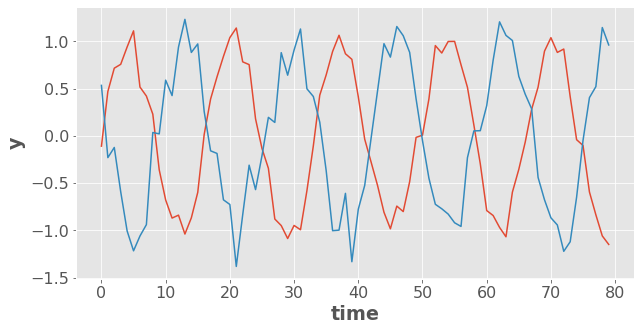

In [24]:
N = 80  # control the resolution of the sine wave
np.random.seed(123)
x = np.linspace(0, 30, N)
y1 = np.sin(x) + np.random.normal(0, 0.1, N)
y2 = np.cos(x - 5) + np.random.normal(0, 0.2, N)
plt.subplots(1, 1, figsize=(10, 5))
plt.plot(y1)
plt.plot(y2)
plt.xlabel('time')
plt.ylabel('y')
df = pd.DataFrame({'y1': y1,
                   'y2': y2})

In [25]:
df_lag = lag_df(df, 2, ['y1', 'y2']).dropna()
df_lag

,y1,y2,y1-1,y2-1,y1-2,y2-2
2,0.716852,-0.122373,0.470420,-0.229779,-0.108563,0.534710
3,0.757687,-0.590893,0.716852,-0.122373,0.470420,-0.229779
4,0.940798,-1.005900,0.757687,-0.590893,0.716852,-0.122373
5,1.111852,-1.216367,0.940798,-1.005900,0.757687,-0.590893
6,0.517201,-1.059551,1.111852,-1.216367,0.940798,-1.005900
...,...,...,...,...,...,...
75,-0.101238,-0.047255,-0.040105,-0.648488,0.415365,-1.120301
76,-0.593724,0.405159,-0.101238,-0.047255,-0.040105,-0.648488
77,-0.835319,0.521539,-0.593724,0.405159,-0.101238,-0.047255
78,-1.058573,1.146979,-0.835319,0.521539,-0.593724,0.405159


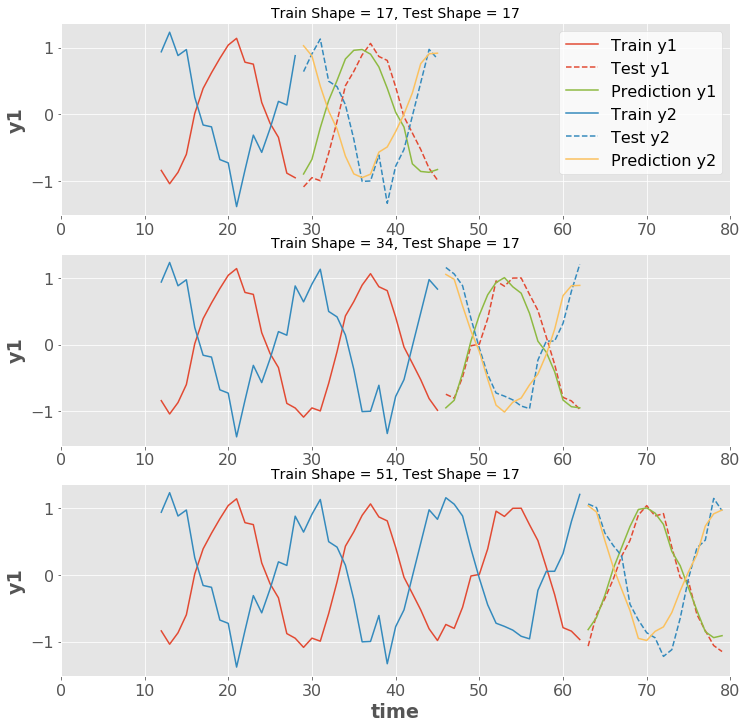

In [26]:
lag = 12
n_splits = 3
fig, ax = plt.subplots(n_splits, 1, figsize=(12,n_splits*4))
df_lag = lag_df(df, cols=df.columns, lag=lag).dropna()
tscv = TimeSeriesSplit(n_splits=n_splits)
for i, (train_index, test_index) in enumerate(tscv.split(df_lag)):
    df_train, df_test = df_lag.iloc[train_index], df_lag.iloc[test_index]
    model = RandomForestRegressor().fit(df_train.drop(columns=['y1', 'y2']),
                                        df_train[['y1', 'y2']])  # train model
    # Prediction loop
    input_data = df_lag.iloc[-1, :lag*df.shape[1]].to_numpy()  # starting data for first prediction
    predictions = ts_predict(input_data, model, len(df_test), responses=2)
    
    # Plot
    plot_ts(ax[i], df_train, df_test, predictions, xlim=df_lag.index[-1], response_cols=['y1', 'y2'])
ax[0].legend(facecolor='w')
ax[i].set_xlabel('time');

- Let's try a forecast!

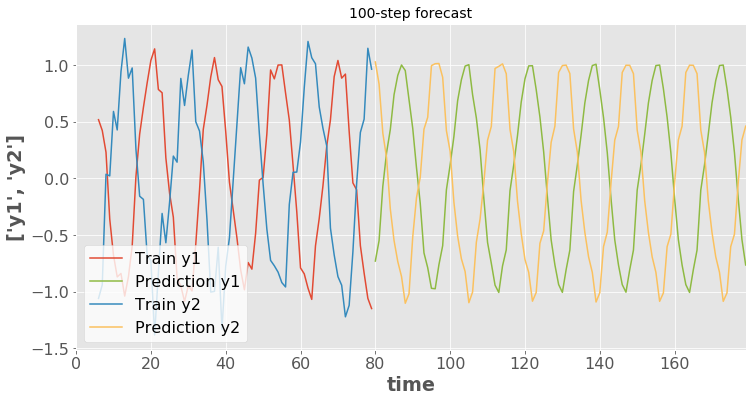

In [27]:
lag = 6
n = 100
fig, ax = plt.subplots(1, 1, figsize=(12,6))
df_lag = lag_df(df, cols=df.columns, lag=lag).dropna()
model = RandomForestRegressor().fit(df_lag.drop(columns=['y1', 'y2']),
                                    df_lag[['y1', 'y2']])
# Prediction loop
input_data = df_lag.iloc[-1, :lag*df.shape[1]].to_numpy()  # starting data for first prediction
predictions = ts_predict(input_data, model, n, responses=2)

# Plot
plot_forecast(ax, df_lag, predictions, xlim=df_lag.index[-1], response_cols=['y1', 'y2'])
ax.legend(loc=3, facecolor='w')
ax.set_xlabel('time');

# Recurrent neural networks

- Another option you might want to explore for modelling time series data is recurrent neural networks
- Long-short-term-memory (LSTM) networks have been particularly popular for time series data
- I don't have time to talk about them here, but:
    - here is an [excellent blog post](https://colah.github.io/posts/2015-08-Understanding-LSTMs/) on the topic
    - and here is a [good Tensorflow tutorial](https://www.tensorflow.org/tutorials/structured_data/time_series)

# My recommendations for working with time series

1. Train/test split first
2. EDA! Understand and visualize your data
3. Try classic models first (e.g., ARIMA, exponential smoothingmodels)
4. Try classic supervised learning (e.g., random forest, kNN)
5. Feature engineer!
6. (If you have time/think you can do better): LSTMs


Finally, some potentially useful python packages/resources:

- [tslearn](https://github.com/tslearn-team/tslearn)
- [sktime](https://github.com/alan-turing-institute/sktime)
- [facebook's prophet](https://github.com/facebook/prophet)
- [microsoft's resources](https://github.com/microsoft/forecasting)